In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
from IPython.display import Image
import matplotlib.cm as cm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.preprocessing import LabelBinarizer
import tensorflow as tf
import seaborn as sns
import shutil
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc, precision_recall_curve

In [2]:
import os

def count_images_in_folder(folder_path):
    # List of common image file extensions
    image_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.gif'}
    
    # Initialize image count
    image_count = 0
    
    # Traverse through the directory
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            # Check if the file has an image extension
            if os.path.splitext(file)[1].lower() in image_extensions:
                image_count += 1
    
    return image_count

# Call the function to get the number of images
no_dr_images = count_images_in_folder('/kaggle/input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images/No_DR')
print(f"Number of images in the No_DR folder: {no_dr_images}")

mild_images = count_images_in_folder('/kaggle/input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images/Mild')
print(f"Number of images in the Mild folder: {mild_images}")

moderate_images = count_images_in_folder('/kaggle/input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images/Moderate')
print(f"Number of images in the Moderate folder: {moderate_images}")

severe_images = count_images_in_folder('/kaggle/input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images/Severe')
print(f"Number of images in the Severe folder: {severe_images}")

proliferate_images = count_images_in_folder('/kaggle/input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images/Proliferate_DR')
print(f"Number of images in the Proliferate folder: {proliferate_images}")

Number of images in the No_DR folder: 1805
Number of images in the Mild folder: 370
Number of images in the Moderate folder: 999
Number of images in the Severe folder: 193
Number of images in the Proliferate folder: 295


In [3]:
image_dir = Path('/kaggle/input/diabetic-retinopathy-224x224-gaussian-filtered')
# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

In [4]:
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

# Shuffle the DataFrame and reset index
image_df = image_df.sample(frac=1).reset_index(drop = True)

# Show the result
image_df.head(3)

Filepath     Label
0  /kaggle/input/diabetic-retinopathy-224x224-gau...  Moderate
1  /kaggle/input/diabetic-retinopathy-224x224-gau...      Mild
2  /kaggle/input/diabetic-retinopathy-224x224-gau...  Moderate

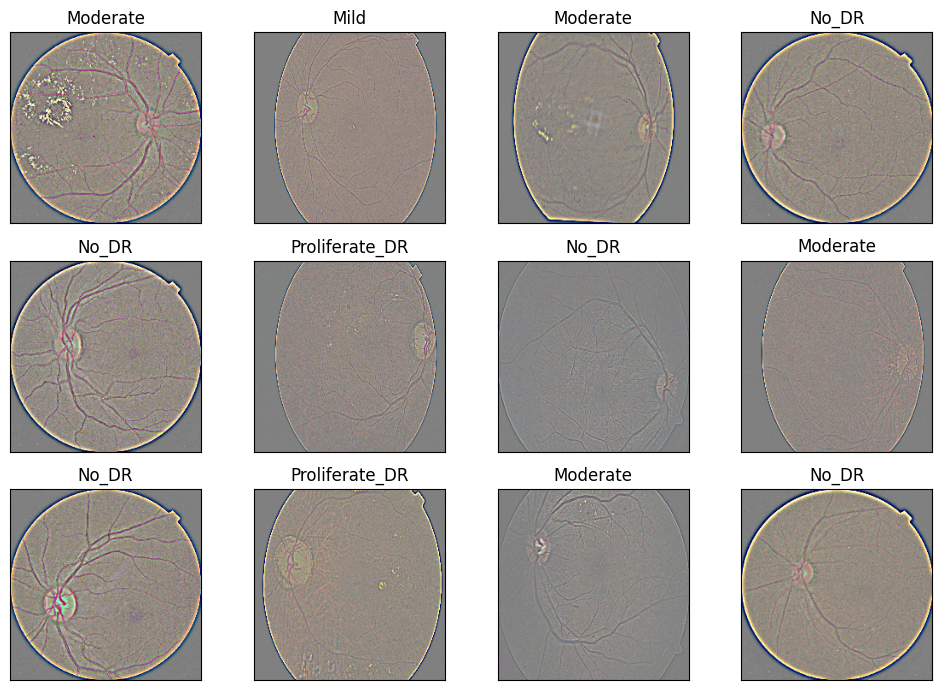

In [5]:
# Display some pictures of the dataset with their labels
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(10, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[i]))
    ax.set_title(image_df.Label[i])
plt.tight_layout()
plt.show()

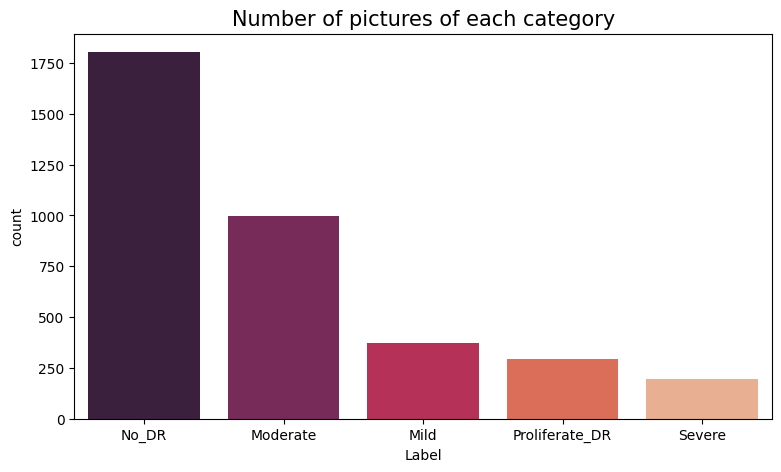

In [6]:
# Display the number of pictures of each category
vc = image_df['Label'].value_counts()
plt.figure(figsize=(9,5))
sns.barplot(x = vc.index, y = vc, palette = "rocket")
plt.title("Number of pictures of each category", fontsize = 15)
plt.show()

In [7]:
def create_gen():
    # Load the Images with a generator and Data Augmentation
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        validation_split=0.1
    )

    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )

    train_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='training',
        rotation_range=30, # Uncomment to use data augmentation
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    val_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='validation',
        rotation_range=30, # Uncomment to use data augmentation
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )
    
    return train_generator,test_generator,train_images,val_images,test_images

In [8]:
# Load the MobileNetV2 pretained model
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [9]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, train_size=0.8, shuffle=True, random_state=1,  stratify=labels)

In [10]:
# Create the generators
train_generator,test_generator,train_images,val_images,test_images=create_gen()
print('\n')

Found 2637 validated image filenames belonging to 5 classes.
Found 292 validated image filenames belonging to 5 classes.
Found 733 validated image filenames belonging to 5 classes.




In [11]:
print(pretrained_model.output.shape)

(None, 1280)


In [12]:
inputs = pretrained_model.input

# x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
# x = tf.keras.layers.Dense(128, activation='relu')(x)
# x = Dropout(0.5)(x)

# outputs = tf.keras.layers.Dense(5, activation='softmax')(x)

# model = tf.keras.Model(inputs=inputs, outputs=outputs)

x = pretrained_model.output
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)  # Dropout layer to reduce overfitting
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)  # Another dropout for regularization
outputs = Dense(5, activation='softmax')(x)


model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# model.compile(optimizer=tf.keras.optimizers.Adam(), 
#               loss=focal_loss(gamma=2., alpha=0.25),  # Using manually implemented Focal Loss
#               metrics=['accuracy'])

In [13]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 4,097,093 (15.63 MB)

 Trainable params: 1,839,109 (7.02 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [14]:
history = model.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        )
    ]
)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


83/83 ━━━━━━━━━━━━━━━━━━━━ 86s 932ms/step - accuracy: 0.6164 - loss: 1.2311 - val_accuracy: 0.7568 - val_loss: 0.6972
Epoch 2/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 76s 902ms/step - accuracy: 0.7349 - loss: 0.7355 - val_accuracy: 0.7568 - val_loss: 0.6641
Epoch 3/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 75s 896ms/step - accuracy: 0.7440 - loss: 0.7042 - val_accuracy: 0.7568 - val_loss: 0.6593
Epoch 4/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 78s 935ms/step - accuracy: 0.7540 - loss: 0.6613 - val_accuracy: 0.7226 - val_loss: 0.6910
Epoch 5/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 76s 902ms/step - accuracy: 0.7494 - loss: 0.6512 - val_accuracy: 0.7671 - val_loss: 0.6539
Epoch 6/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 79s 941ms/step - accuracy: 0.7665 - loss: 0.6283 - val_accuracy: 0.7671 - val_loss: 0.6337
Epoch 7/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 76s 903ms/step - accuracy: 0.7500 - loss: 0.6287 - val_accuracy: 0.7671 - val_loss: 0.6333
Epoch 8/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 76s 902ms/step - accuracy: 0.7645 - loss: 0.6117 - val_accuracy

## Show Graphical comparision

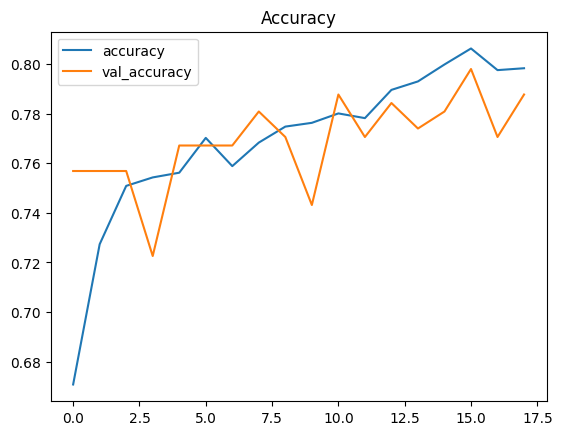

In [15]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

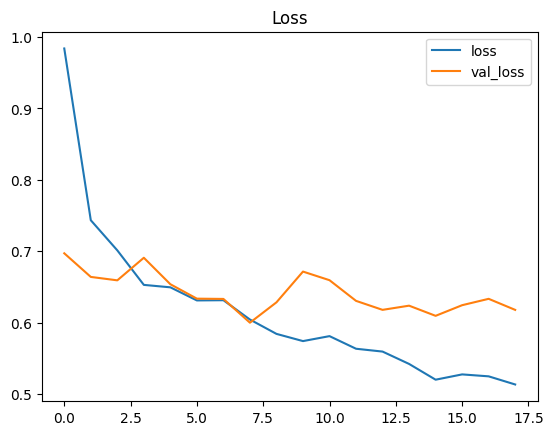

In [16]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [17]:
results = model.evaluate(test_images, verbose=0)
print("Test Loss: {:.5f}".format(results[0]))
print("Accuracy on the test set: {:.2f}%".format(results[1] * 100))

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Test Loss: 0.61854
Accuracy on the test set: 77.76%


In [18]:
# Predict the label of the test_images
y_pred_probs = model.predict(test_images)
pred = np.argmax(y_pred_probs,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

23/23 ━━━━━━━━━━━━━━━━━━━━ 21s 835ms/step
The first 5 predictions: ['Moderate', 'Moderate', 'No_DR', 'Moderate', 'Moderate']


In [19]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

                precision    recall  f1-score   support

          Mild       0.58      0.49      0.53        67
      Moderate       0.63      0.87      0.73       204
         No_DR       0.93      0.97      0.95       358
Proliferate_DR       0.59      0.16      0.25        63
        Severe       0.50      0.07      0.13        41

      accuracy                           0.78       733
     macro avg       0.65      0.51      0.52       733
  weighted avg       0.76      0.78      0.74       733



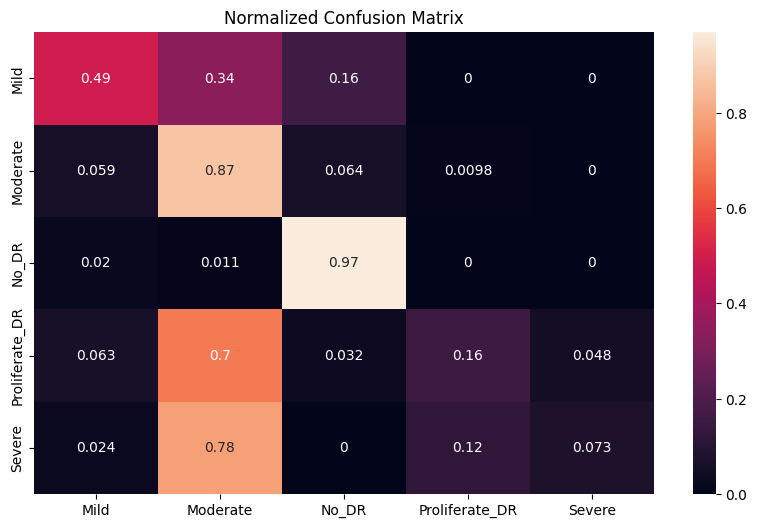

In [20]:
cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

In [21]:
# Compute metrics
precision = precision_score(y_test, pred, average='weighted')
recall = recall_score(y_test, pred, average='weighted')
f1 = f1_score(y_test, pred, average='weighted')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Precision: 0.7617339924669466
Recall: 0.7776261937244202
F1 Score: 0.744517819111984


In [22]:
y_true = y_test
y_pred = pred

# Binarize the labels for multiclass classification
lb = LabelBinarizer()
y_true_binarized = lb.fit_transform(y_true)
y_pred_binarized = lb.transform(y_pred)
classes = lb.classes_

# ROC AUC score for each class
roc_auc_scores = {}
for idx, class_name in enumerate(lb.classes_):
    roc_auc_scores[class_name] = roc_auc_score(y_true_binarized[:, idx], y_pred_binarized[:, idx])

print("ROC AUC Scores by Class:")
for class_name, score in roc_auc_scores.items():
    print(f"Class {class_name}: {score:.4f}")

# Overall micro and macro ROC AUC scores
overall_micro_auc = roc_auc_score(y_true_binarized, y_pred_binarized, average='micro')
overall_macro_auc = roc_auc_score(y_true_binarized, y_pred_binarized, average='macro')
print("\n")
print(f"Overall Micro ROC AUC: {overall_micro_auc:.4f}")
print(f"Overall Macro ROC AUC: {overall_macro_auc:.4f}")

ROC AUC Scores by Class:
Class Mild: 0.7283
Class Moderate: 0.8365
Class No_DR: 0.9500
Class Proliferate_DR: 0.5741
Class Severe: 0.5344


Overall Micro ROC AUC: 0.8610
Overall Macro ROC AUC: 0.7246


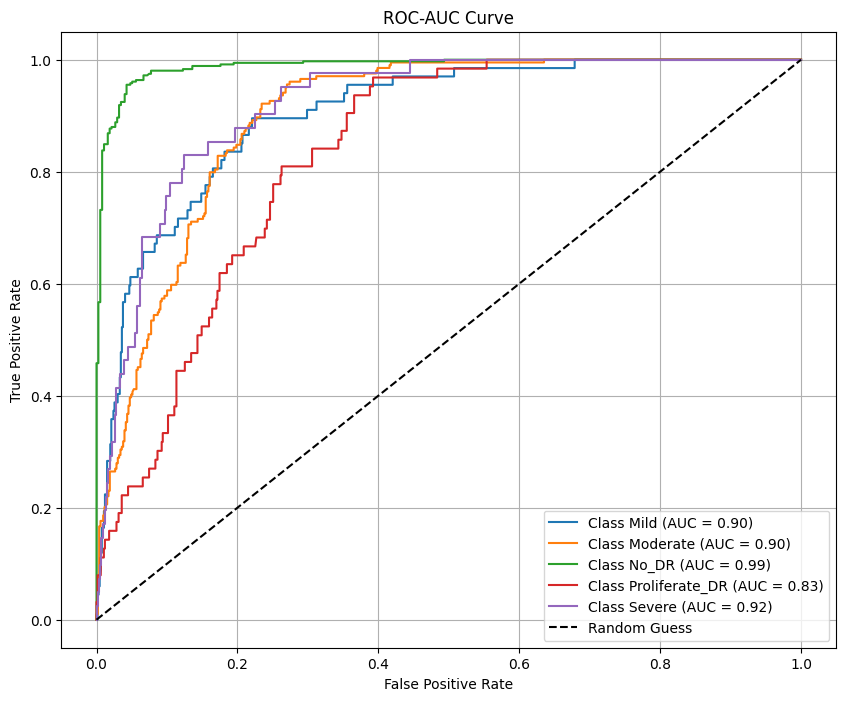

In [23]:
# ROC-AUC Curve for each class
plt.figure(figsize=(10, 8))
for idx, class_name in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_true_binarized[:, idx], y_pred_probs[:, idx])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {class_name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-AUC Curve")
plt.legend()
plt.grid()
plt.show()

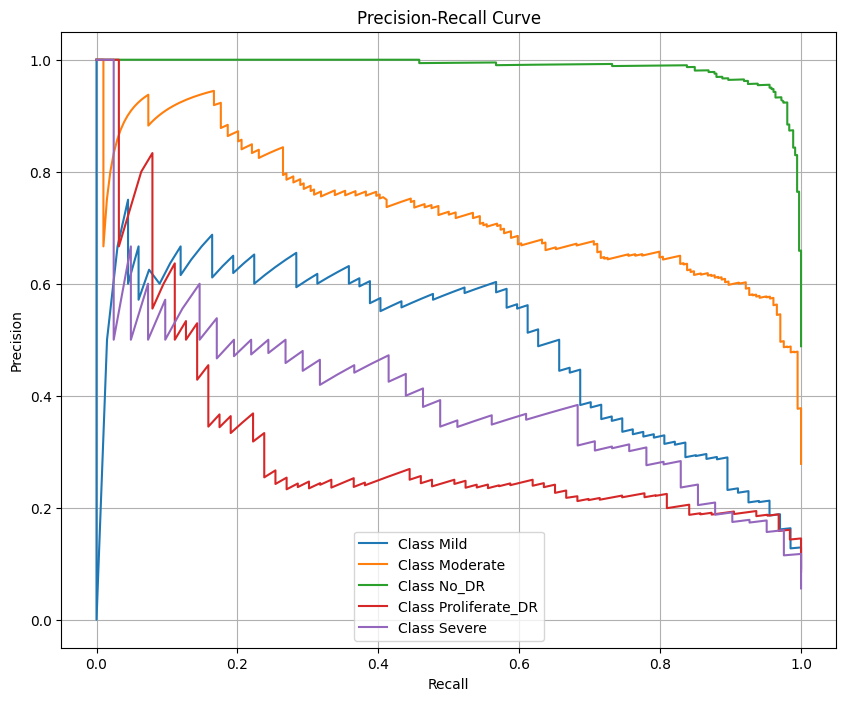

In [24]:
# Precision-Recall Curve for each class
plt.figure(figsize=(10, 8))
for idx, class_name in enumerate(classes):
    precision, recall, _ = precision_recall_curve(y_true_binarized[:, idx], y_pred_probs[:, idx])
    plt.plot(recall, precision, label=f"Class {class_name}")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid()
plt.show()

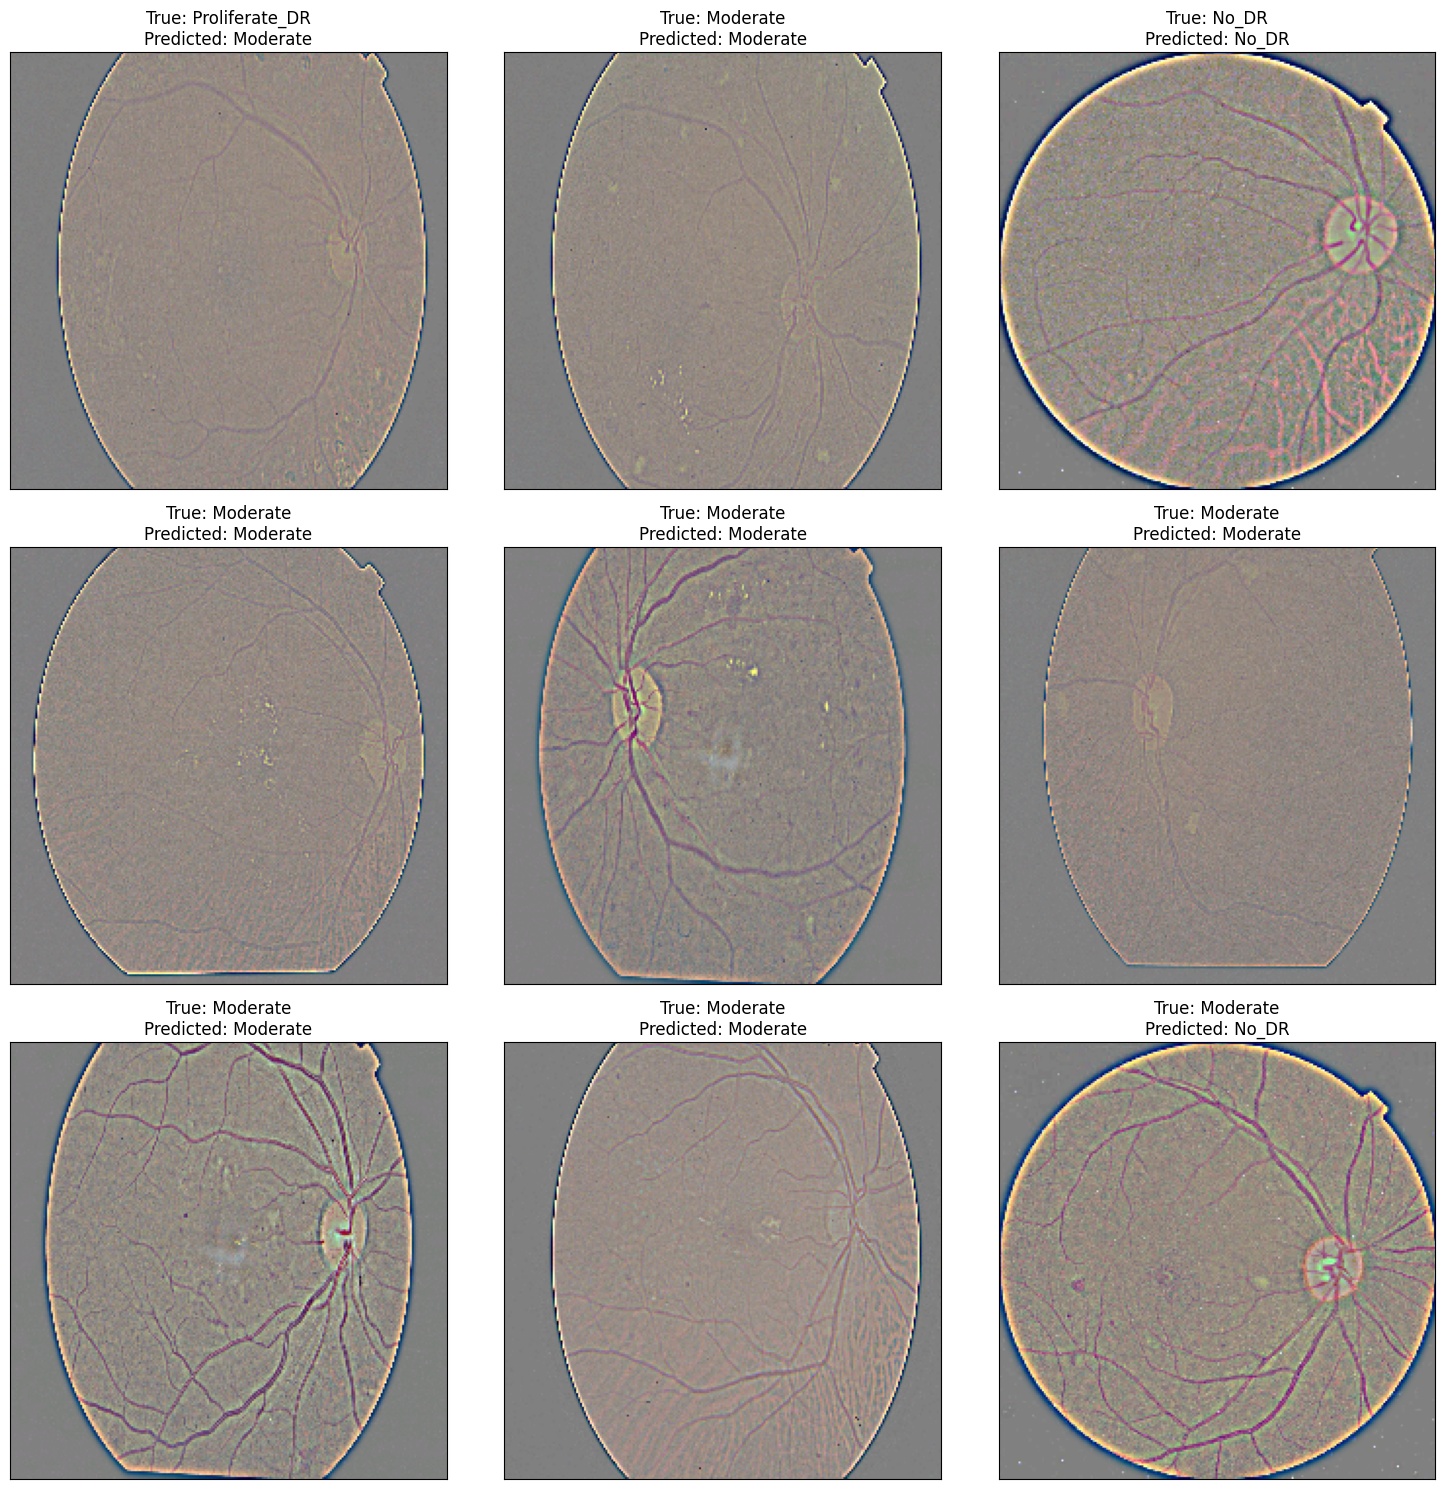

In [25]:
# Display some pictures of the dataset with their labels and the predictions
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()

In [26]:
model.save('my_model.h5')

In [27]:
shutil.move('my_model.h5', '/kaggle/working/my_model.h5')

'/kaggle/working/my_model.h5'